In [ ]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt

from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

NOMINAL_RABI_FREQ_BASE_HZ = 100e6
RABI_MAX_RANGE = np.linspace(98e6, 102e6, 5)
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)

rabi_maxes = []
errors_freq_nT = []
errors_time_nT = []

for rabi_max in RABI_MAX_RANGE:

    # Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
    exp_param_factory.set_base_rabi_frequency(rabi_max)
    sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

    larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())

    # Run the analysis assuming the nominal Rabi frequency
    exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
    rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
    try:    
        # frequency domain inversion
        peakfit_results = double_cosine_inner_product_fit_inversion(
            sq_cancelled_signal,
            rabi_frequencies,
            inner_product_settings,
            RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
            T2STAR_S,
            constrain_same_width=True,
            allow_zero_peak=True,
        )
        errors_fd_nT = fit_vs_eigenvalue_error_all_orientations_nT(peakfit_results, larmor_freqs_all_axes_hz)
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz, freq domain errors = {np.array2string(errors_fd_nT[:, PEAK_INDEX], precision=2)} nT") 

        # time domain inversion
        freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
        time_domain_fit_results = time_domain_fit_inversion(
            sq_cancelled_signal, 
            exp_param_factory.get_experiment_parameters(), 
            inner_product_settings, 
            freq_guesses_all_orientations, 
            T2STAR_S,
            fix_phase_to_zero= False,
            constrain_same_decay= True,
            constrain_hyperfine_freqs= True)
        errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
        print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

        rabi_maxes.append(rabi_max)
        errors_freq_nT.append(errors_fd_nT[:, PEAK_INDEX])
        errors_time_nT.append(errors_td_nT[:, PEAK_INDEX])
        
    except ValueError:
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz generated ValueError ")




IndexError: index -1 is out of bounds for axis 0 with size 0

It looks like we need to find a good guess for both the Rabi frequency and the Larmor frequencies -- i.e. we should do peak-finding in 2D...

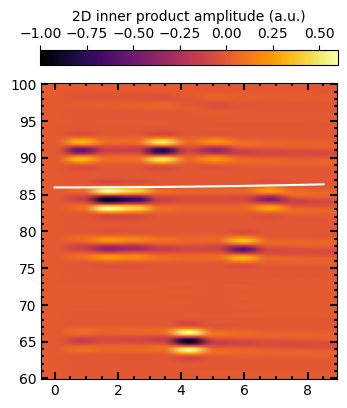

In [ ]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt

from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations
from bff_paper_figures.imshow_extensions import imshow_with_extents_and_crop

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

NOMINAL_RABI_FREQ_BASE_HZ = 100e6
RABI_MAX_RANGE = np.linspace(98e6, 102e6, 5)
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)
EXAMPLE_ORIENTATION = 3

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)

# Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
rabi_max = RABI_MAX_RANGE[0]
exp_param_factory.set_base_rabi_frequency(rabi_max)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())

# Run the analysis assuming the nominal Rabi frequency
exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)

ramseyfreqs = np.linspace(0, 8.5e6, 11)
rabifreqs = np.linspace(60e6, 100e6, 201)
dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
imshow_with_extents_and_crop(HZ_TO_MHZ*ramseyfreqs,HZ_TO_MHZ*rabifreqs, -dtft/min(dtft.flatten()),ymin=60, ymax=100, xmin=0, xmax=8.5)
plt.colorbar(orientation="horizontal",location="top", shrink=0.6, label="2D inner product amplitude (a.u.)")
plt.plot(HZ_TO_MHZ*ramseyfreqs, np.sqrt((HZ_TO_MHZ*rabi_frequencies[EXAMPLE_ORIENTATION])**2 + (HZ_TO_MHZ*ramseyfreqs)**2), color="white")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both", width=1.5)
plt.gca().tick_params(direction="in", which = "minor", length=2.5)
plt.gca().tick_params(direction="in", which = "major", length=5)
plt.show()

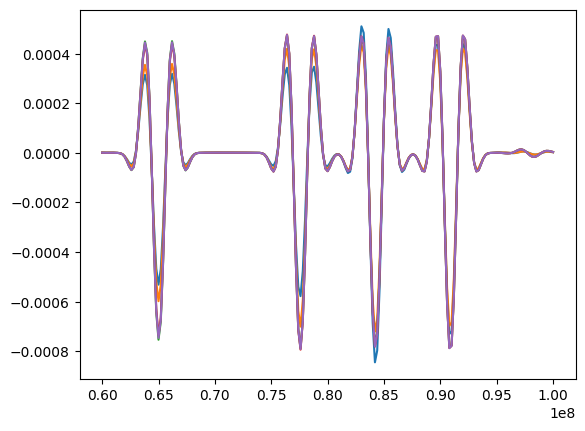

65000000.0
[65020730.49661703]
77600000.0
[77579950.17904788]
84200000.0
[84248134.54432413]
90800000.0
[90890920.77716021]


In [ ]:
from scipy.optimize import minimize
height_factor = 0.25
prominence_factor = 0.25

for n_ramsey in np.linspace(11, 51, 5):
    ramseyfreqs= np.linspace(0, 8.5e6, int(n_ramsey)) 
    rabifreqs=np.linspace(60e6, 100e6, 201)
    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)/len(ramseyfreqs)


min_rs = min(ramsey_summed)
max_rs = max(ramsey_summed)
peaks = find_peaks(
    -ramsey_summed,
    height=(-min_rs) * height_factor,
    prominence=(-min_rs) * prominence_factor,
)


def ramsey_summed_dtft_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings, ramseyfreqs):
    return np.sum(np.array([double_cosine_inner_product(sq_cancelled_signal, rabi_freq[0], ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs]))

for rabi_guess in rabifreqs[peaks[0]]:
    print(rabi_guess)
    peak = minimize(ramsey_summed_dtft_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings, ramseyfreqs), method="Nelder-Mead")
    print(peak.x)




In [19]:
print(peaks)

(array([10, 26, 35, 43]), {'peak_heights': array([0.00860223, 0.01467594, 0.0108833 , 0.0133278 ]), 'prominences': array([0.0159873 , 0.0221605 , 0.01977862, 0.0210004 ]), 'left_bases': array([ 8, 11, 33, 33]), 'right_bases': array([11, 33, 36, 45])})


In [ ]:
from scipy.signal import find_peaks
def ramsey_summed_dtft_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings, ramseyfreqs):
    return np.sum(np.array([double_cosine_inner_product(sq_cancelled_signal, rabi_freq[0], ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs]))


def find_rabi_frequencies_from_signal_old(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 51), rabifreqs=np.linspace(60e6, 100e6, 501), height_factor = 0.5, prominence_factor = 0.5, ordering=[0,1,3,2]):

    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)
    min_rs = min(ramsey_summed)
    peaks = find_peaks(
        -ramsey_summed,
        height=(-min_rs) * height_factor,
        prominence=(-min_rs) * prominence_factor,
    )
    return np.array(rabifreqs[peaks[0]])[ordering]

def find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 11), rabifreqs=np.linspace(60e6, 100e6, 501), height_factor = 0.5, prominence_factor = 0.5, ordering=[0,1,3,2]):

    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)

    min_rs = min(ramsey_summed)
    peaks = find_peaks(
        -ramsey_summed,
        height=(-min_rs) * height_factor,
        prominence=(-min_rs) * prominence_factor,
    )
    rabi_frequencies = []
    for rabi_guess in rabifreqs[peaks[0]]:
        peak = minimize(ramsey_summed_dtft_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings, ramseyfreqs), method="Nelder-Mead")
        rabi_frequencies.append(peak.x[0])

    return np.array(rabi_frequencies)[ordering]

Ideal Rabi frequencies: [33.18 39.59 46.38 42.98]
Extracted Rabi frequencies: [33.15 39.53 46.36 43.  ]
Rabi_max = 50.00 MHz, freq domain errors = [30.7   7.91 -1.24 -4.74] nT
	 	 	 time domain fit errors = [  0.223   1.41  -12.993  -0.298] nT
Ideal Rabi frequencies: [33.85 40.38 47.31 43.84]
Extracted Rabi frequencies: [33.81 40.32 47.29 43.86]
Rabi_max = 51.00 MHz, freq domain errors = [31.11  6.04 -2.85 -3.43] nT
	 	 	 time domain fit errors = [ 0.304  1.005 -9.068 -0.4  ] nT
Ideal Rabi frequencies: [34.51 41.17 48.23 44.7 ]


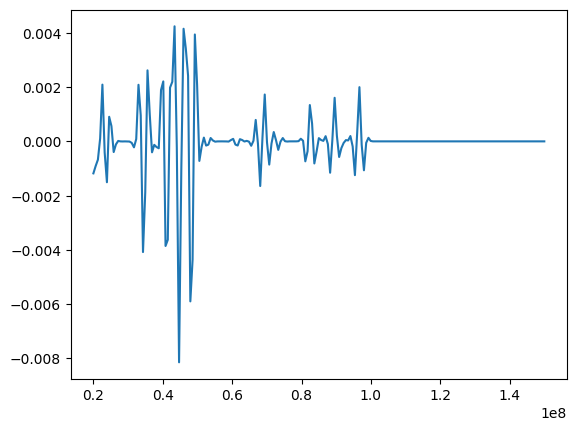

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [34.47 41.11 48.21 44.72]
Rabi_max = 52.00 MHz, freq domain errors = [31.55  6.82 -1.81 -6.47] nT
	 	 	 time domain fit errors = [ 0.211  0.605 -6.511 -0.443] nT
Ideal Rabi frequencies: [35.17 41.96 49.16 45.56]
Extracted Rabi frequencies: [35.14 41.9  49.14 45.58]
Rabi_max = 53.00 MHz, freq domain errors = [31.99  7.58 -3.3  -2.26] nT
	 	 	 time domain fit errors = [-0.471  0.287 -4.748 -0.464] nT
Ideal Rabi frequencies: [35.84 42.75 50.09 46.42]
Extracted Rabi frequencies: [35.8  42.7  50.07 46.44]
Rabi_max = 54.00 MHz, freq domain errors = [32.36  6.02 -1.96 -3.34] nT
	 	 	 time domain fit errors = [-1.21   0.102 -3.564 -0.454] nT
Ideal Rabi frequencies: [36.5  43.55 51.02 47.28]


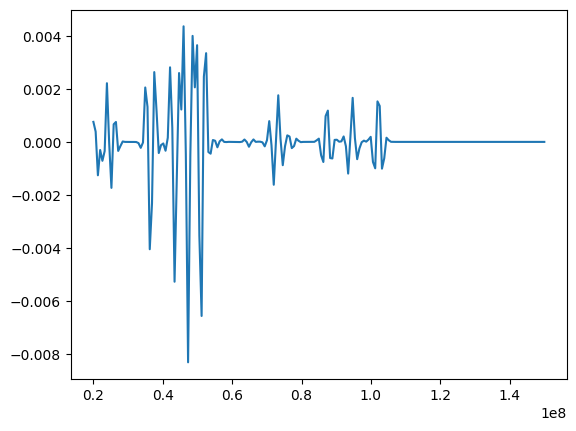

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [36.46 43.49 51.   47.3 ]
Rabi_max = 55.00 MHz, freq domain errors = [32.67  4.92 -3.66 -3.92] nT
	 	 	 time domain fit errors = [-1.622  0.05  -2.489 -0.433] nT
Ideal Rabi frequencies: [37.16 44.34 51.94 48.14]
Extracted Rabi frequencies: [37.13 44.28 51.92 48.15]
Rabi_max = 56.00 MHz, freq domain errors = [32.96  5.93 -2.31 -0.34] nT
	 	 	 time domain fit errors = [-1.079  0.121 -1.654 -0.369] nT
Ideal Rabi frequencies: [37.83 45.13 52.87 49.  ]
Extracted Rabi frequencies: [37.79 45.07 52.85 49.02]
Rabi_max = 57.00 MHz, freq domain errors = [33.25  6.18 -3.98 -3.18] nT
	 	 	 time domain fit errors = [-0.311  0.219 -1.018 -0.239] nT
Ideal Rabi frequencies: [38.49 45.92 53.8  49.86]


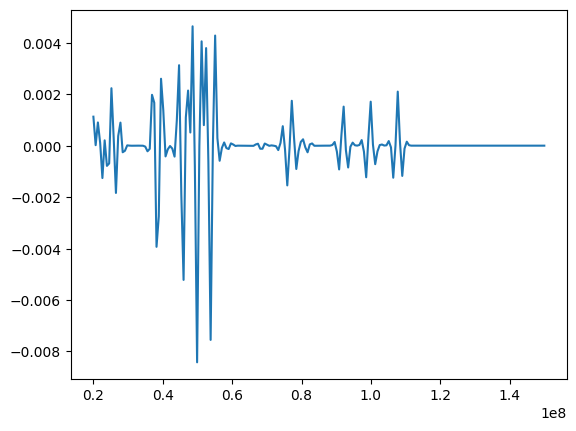

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [38.45 45.86 53.78 49.88]
Rabi_max = 58.00 MHz, freq domain errors = [33.51  4.5  -2.59 -1.44] nT
	 	 	 time domain fit errors = [ 0.383  0.271 -0.655 -0.062] nT
Ideal Rabi frequencies: [39.16 46.71 54.73 50.72]
Extracted Rabi frequencies: [39.11 46.66 54.71 50.73]
Rabi_max = 59.00 MHz, freq domain errors = [33.74  3.77 -4.05  0.07] nT
	 	 	 time domain fit errors = [ 0.441  0.239 -0.376  0.085] nT
Ideal Rabi frequencies: [39.82 47.5  55.65 51.58]
Extracted Rabi frequencies: [39.78 47.45 55.63 51.6 ]
Rabi_max = 60.00 MHz, freq domain errors = [33.99  4.57 -2.69 -2.53] nT
	 	 	 time domain fit errors = [ 0.37   0.101 -0.198  0.114] nT
Ideal Rabi frequencies: [40.48 48.3  56.58 52.44]


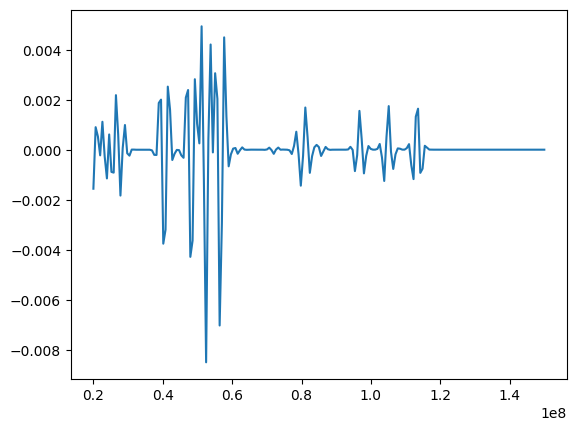

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [40.44 48.24 56.57 52.45]
Rabi_max = 61.00 MHz, freq domain errors = [34.3   4.29 -3.87  0.74] nT
	 	 	 time domain fit errors = [ 0.111 -0.074 -0.107  0.058] nT
Ideal Rabi frequencies: [41.15 49.09 57.51 53.3 ]


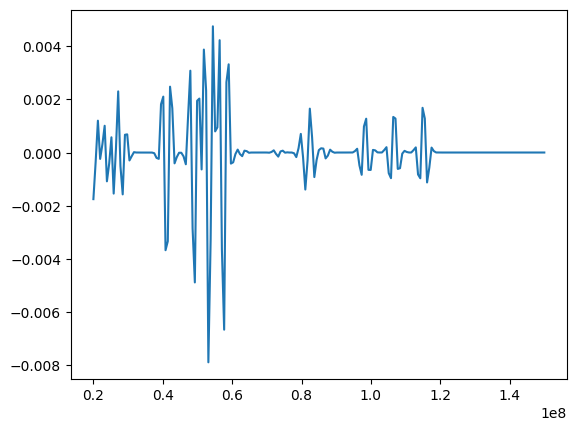

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [41.1  49.03 57.49 53.31]
Rabi_max = 62.00 MHz, freq domain errors = [34.63  2.81 -2.7   0.11] nT
	 	 	 time domain fit errors = [-0.092 -0.203 -0.13  -0.061] nT
Ideal Rabi frequencies: [41.81 49.88 58.44 54.16]


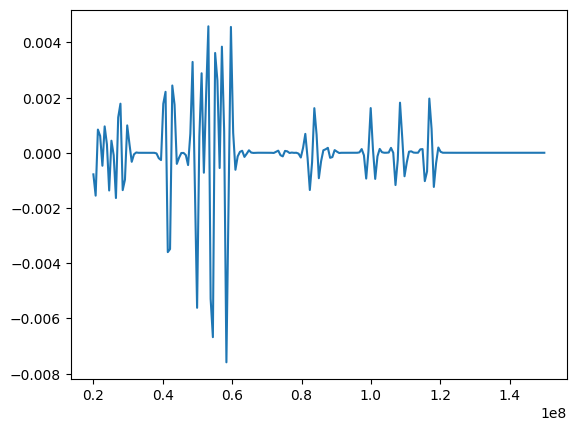

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [41.77 49.83 58.42 54.17]
Rabi_max = 63.00 MHz, freq domain errors = [34.94  2.74 -3.69 -0.57] nT
	 	 	 time domain fit errors = [-0.458 -0.236 -0.186 -0.178] nT
Ideal Rabi frequencies: [42.47 50.67 59.36 55.02]


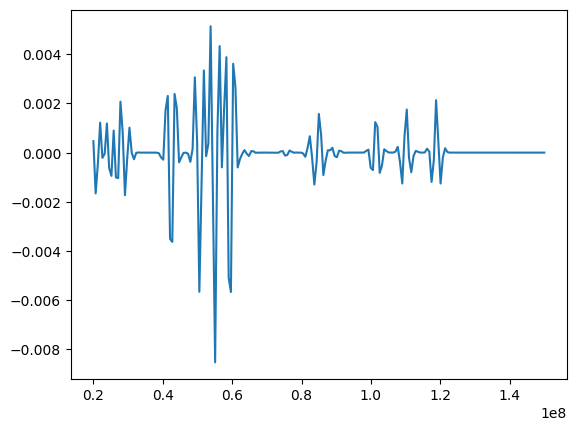

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [42.43 50.62 59.35 55.03]
Rabi_max = 64.00 MHz, freq domain errors = [35.25  3.7  -2.84  2.72] nT
	 	 	 time domain fit errors = [-0.677 -0.128 -0.187 -0.282] nT
Ideal Rabi frequencies: [43.14 51.46 60.29 55.88]


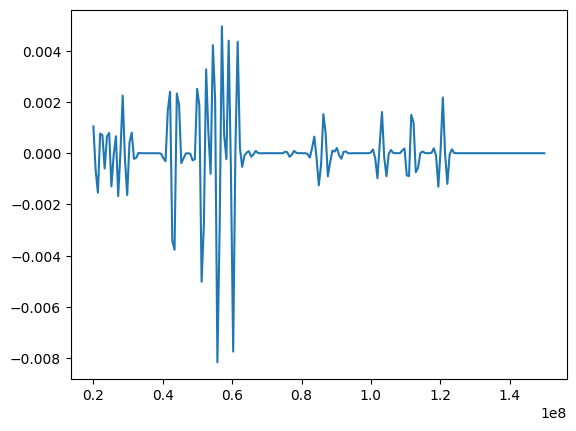

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [43.1  51.41 60.28 55.89]
Rabi_max = 65.00 MHz, freq domain errors = [35.61  3.3  -3.61  0.66] nT
	 	 	 time domain fit errors = [-0.683  0.09  -0.15  -0.328] nT
Ideal Rabi frequencies: [43.8  52.26 61.22 56.74]
Extracted Rabi frequencies: [43.76 52.2  61.2  56.75]
Rabi_max = 66.00 MHz, freq domain errors = [36.06  2.21 -3.03  2.07] nT
	 	 	 time domain fit errors = [-0.443  0.337 -0.177 -0.376] nT
Ideal Rabi frequencies: [44.46 53.05 62.15 57.6 ]


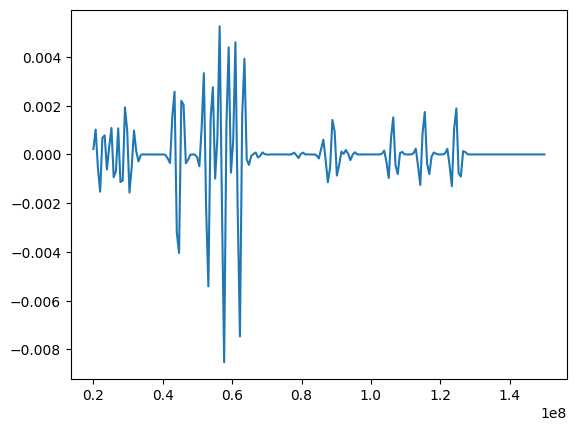

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [44.42 53.   62.13 57.61]
Rabi_max = 67.00 MHz, freq domain errors = [36.53  2.46 -3.43  3.85] nT
	 	 	 time domain fit errors = [-0.161  0.562 -0.319 -0.414] nT
Ideal Rabi frequencies: [45.13 53.84 63.07 58.46]


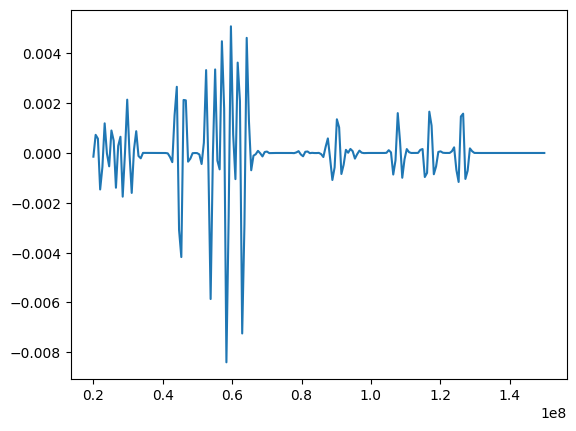

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [45.09 53.79 63.06 58.47]
Rabi_max = 68.00 MHz, freq domain errors = [37.01  2.97 -3.06  1.62] nT
	 	 	 time domain fit errors = [ 0.037  0.663 -0.488 -0.393] nT
Ideal Rabi frequencies: [45.79 54.63 64.   59.32]
Extracted Rabi frequencies: [45.75 54.58 63.99 59.33]
Rabi_max = 69.00 MHz, freq domain errors = [37.46  1.97 -3.14  4.26] nT
	 	 	 time domain fit errors = [ 0.255  0.611 -0.627 -0.327] nT
Ideal Rabi frequencies: [46.46 55.42 64.93 60.18]
Extracted Rabi frequencies: [46.42 55.37 64.91 60.19]
Rabi_max = 70.00 MHz, freq domain errors = [37.87  0.83 -3.04  3.85] nT
	 	 	 time domain fit errors = [ 0.385  0.445 -0.716 -0.197] nT
Ideal Rabi frequencies: [47.12 56.21 65.86 61.04]
Extracted Rabi frequencies: [47.08 56.16 65.84 61.05]
Rabi_max = 71.00 MHz, freq domain errors = [38.21  1.   -2.91  2.65] nT
	 	 	 time domain fit errors = [ 0.398  0.193 -0.755 -0.041] nT
Ideal Rabi frequencies: [47.78 57.01 66.78 61.9 ]
Ext

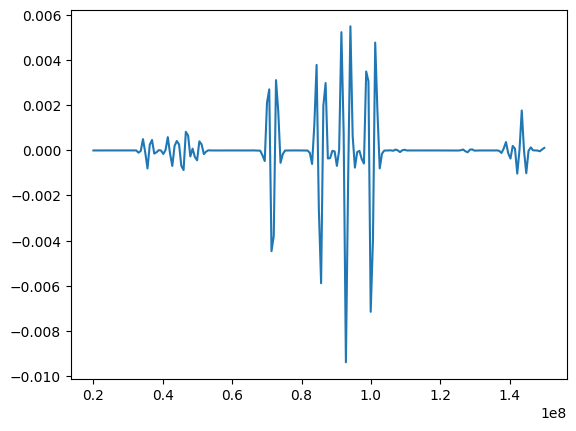

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [ 71.64  85.48 100.16  92.85]
Rabi_max = 108.00 MHz, freq domain errors = [43.05 -5.94 -3.24  9.4 ] nT
	 	 	 time domain fit errors = [ 0.118  0.153 -0.258  0.016] nT
Ideal Rabi frequencies: [ 72.34  86.3  101.1   93.7 ]
Extracted Rabi frequencies: [ 72.31  86.27 101.09  93.71]
Rabi_max = 109.00 MHz, freq domain errors = [43.07 -5.72 -3.74 10.11] nT
	 	 	 time domain fit errors = [ 0.203  0.059 -0.214  0.046] nT
Ideal Rabi frequencies: [ 73.    87.09 102.03  94.56]


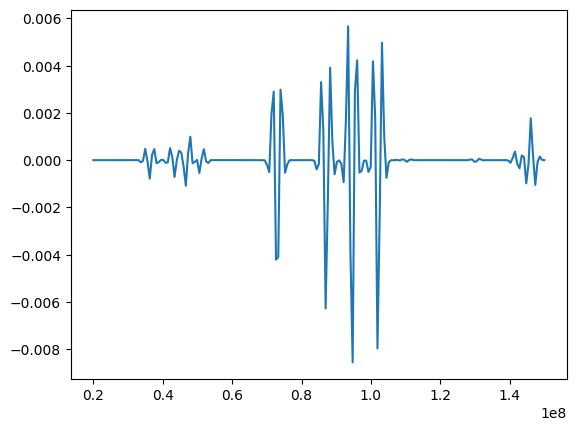

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [ 72.97  87.06 102.02  94.57]
Rabi_max = 110.00 MHz, freq domain errors = [43.1  -5.88 -3.31 10.6 ] nT
	 	 	 time domain fit errors = [ 0.164 -0.035 -0.141  0.063] nT
Ideal Rabi frequencies: [ 73.66  87.88 102.96  95.42]


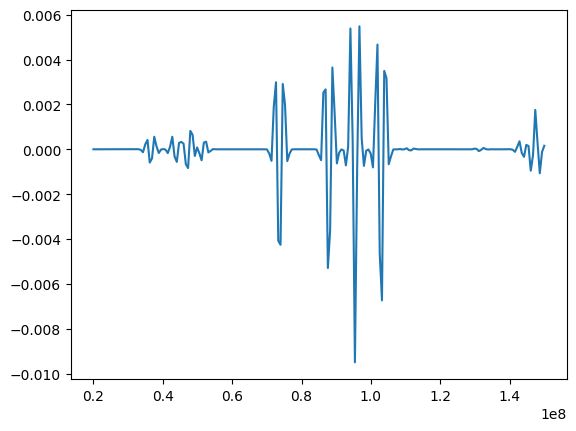

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [ 73.63  87.85 102.95  95.43]
Rabi_max = 111.00 MHz, freq domain errors = [25.69 -6.46 -3.83  9.25] nT
	 	 	 time domain fit errors = [ 0.044 -0.1   -0.025  0.06 ] nT
Ideal Rabi frequencies: [ 74.33  88.68 103.89  96.28]
Extracted Rabi frequencies: [ 74.3   88.64 103.87  96.29]
Rabi_max = 112.00 MHz, freq domain errors = [25.69 -6.53 -3.44 10.64] nT
	 	 	 time domain fit errors = [-0.092 -0.129  0.095  0.053] nT
Ideal Rabi frequencies: [ 74.99  89.47 104.81  97.14]
Extracted Rabi frequencies: [ 74.96  89.43 104.8   97.15]
Rabi_max = 113.00 MHz, freq domain errors = [25.69 -6.28 -3.91 10.07] nT
	 	 	 time domain fit errors = [-0.142 -0.118  0.203  0.031] nT
Ideal Rabi frequencies: [ 75.66  90.26 105.74  98.  ]


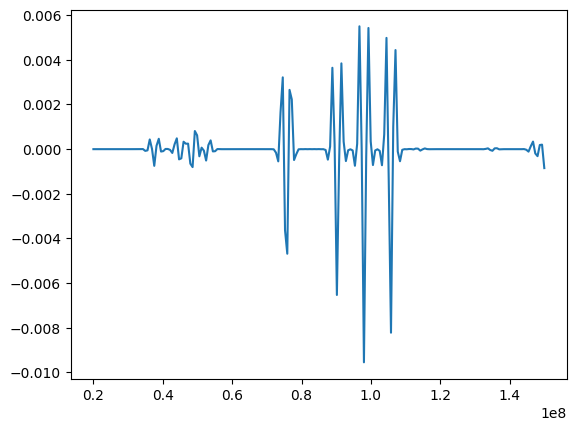

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [ 75.62  90.23 105.73  98.01]
Rabi_max = 114.00 MHz, freq domain errors = [25.69 -6.54 -3.52  9.6 ] nT
	 	 	 time domain fit errors = [-0.113 -0.083  0.26   0.011] nT
Ideal Rabi frequencies: [ 76.32  91.05 106.67  98.86]
Extracted Rabi frequencies: [ 76.29  91.02 106.66  98.87]
Rabi_max = 115.00 MHz, freq domain errors = [25.67 -6.99 -3.91 11.  ] nT
	 	 	 time domain fit errors = [-0.053 -0.049  0.287 -0.005] nT
Ideal Rabi frequencies: [ 76.98  91.84 107.6   99.72]
Extracted Rabi frequencies: [ 76.95  91.81 107.58  99.73]
Rabi_max = 116.00 MHz, freq domain errors = [25.64 -6.84 -3.56  9.78] nT
	 	 	 time domain fit errors = [ 0.007 -0.03   0.292 -0.023] nT
Ideal Rabi frequencies: [ 77.65  92.63 108.52 100.58]
Extracted Rabi frequencies: [ 77.62  92.6  108.51 100.59]
Rabi_max = 117.00 MHz, freq domain errors = [25.6  -6.57 -3.86 10.43] nT
	 	 	 time domain fit errors = [ 0.057 -0.033  0.273 -0.041] nT
Ideal Rabi frequencie

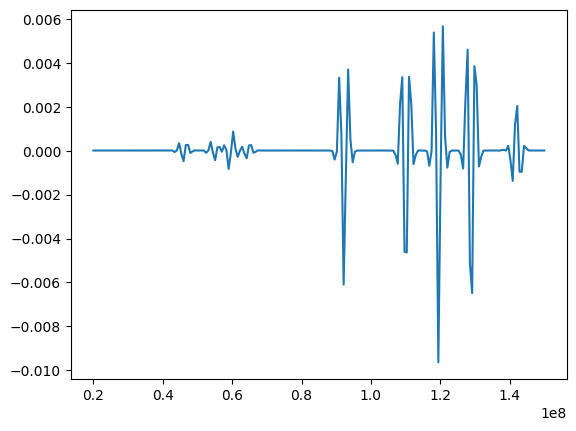

Did not find all peaks! Found only 3
Extracted Rabi frequencies: [ 92.22 110.03 128.92 119.5 ]
Rabi_max = 139.00 MHz, freq domain errors = [24.87 -8.04 -3.6  12.76] nT
	 	 	 time domain fit errors = [ 0.086 -0.037  0.043 -0.042] nT
Ideal Rabi frequencies: [ 92.91 110.84 129.86 120.35]
Extracted Rabi frequencies: [ 92.89 110.82 129.85 120.36]
Rabi_max = 140.00 MHz, freq domain errors = [42.89 -7.98 -3.97 11.85] nT
	 	 	 time domain fit errors = [ 0.048 -0.024 -0.001 -0.026] nT
Ideal Rabi frequencies: [ 93.57 111.64 130.79 121.21]
Extracted Rabi frequencies: [ 93.55 111.61 130.77 121.22]
Rabi_max = 141.00 MHz, freq domain errors = [42.88 -8.37 -3.6  12.04] nT
	 	 	 time domain fit errors = [ 0.017  0.006 -0.039 -0.01 ] nT
Ideal Rabi frequencies: [ 94.24 112.43 131.71 122.07]
Extracted Rabi frequencies: [ 94.21 112.4  131.71 122.08]
Rabi_max = 142.00 MHz, freq domain errors = [42.88 -8.43 -3.97 12.96] nT
	 	 	 time domain fit errors = [-1.540e-02  4.466e-02 -8.446e-02  5.818e-05] nT
Ideal

In [ ]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

NOMINAL_RABI_FREQ_BASE_HZ = 100e6
RABI_MAX_RANGE = np.linspace(50e6, 150e6, 101)
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

def ramsey_summed_dtft_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings, ramseyfreqs):
    return np.sum(np.array([double_cosine_inner_product(sq_cancelled_signal, rabi_freq[0], ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs]))

def find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 11), rabifreqs=np.linspace(20e6, 150e6, 201), height_factor = 0.5, prominence_factor = 0.5, ordering=[0,1,3,2]):

    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)

    min_rs = min(ramsey_summed)
    peaks = find_peaks(
        -ramsey_summed,
        height=(-min_rs) * height_factor,
        prominence=(-min_rs) * prominence_factor,
    )
    if len(peaks[0])!= 4:
        plt.plot(rabifreqs, ramsey_summed)
        plt.show()
    while len(peaks[0]) < 4:
        print(f"Did not find all peaks! Found only {len(peaks[0])}")
        height_factor = height_factor*0.75
        prominence_factor = prominence_factor*0.75
        peaks = find_peaks(
            -ramsey_summed,
            height=(-min_rs) * height_factor,
            prominence=(-min_rs) * prominence_factor,
        )

    rabi_frequencies = []
    for rabi_guess in rabifreqs[peaks[0]]:
        peak = minimize(ramsey_summed_dtft_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings, ramseyfreqs), method="Nelder-Mead")
        rabi_frequencies.append(peak.x[0])

    return np.array(rabi_frequencies)[ordering]

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)

rabi_maxes = []
errors_freq_nT = []
errors_time_nT = []

for rabi_max in RABI_MAX_RANGE:

    # Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
    exp_param_factory.set_base_rabi_frequency(rabi_max)
    sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

    larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
    ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
    print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")
    # Run the analysis assuming the nominal Rabi frequency
    exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
    rabi_frequencies=find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings)
    print(f"Extracted Rabi frequencies: {np.array2string(rabi_frequencies*1e-6, precision=2)}")
    try:    
        # frequency domain inversion
        peakfit_results = double_cosine_inner_product_fit_inversion(
            sq_cancelled_signal,
            rabi_frequencies,
            inner_product_settings,
            RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
            T2STAR_S,
            constrain_same_width=True,
            allow_zero_peak=True,
        )
        errors_fd_nT = fit_vs_eigenvalue_error_all_orientations_nT(peakfit_results, larmor_freqs_all_axes_hz)
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz, freq domain errors = {np.array2string(errors_fd_nT[:, PEAK_INDEX], precision=2)} nT") 

        # time domain inversion
        freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
        time_domain_fit_results = time_domain_fit_inversion(
            sq_cancelled_signal, 
            exp_param_factory.get_experiment_parameters(), 
            inner_product_settings, 
            freq_guesses_all_orientations, 
            T2STAR_S,
            fix_phase_to_zero= False,
            constrain_same_decay= True,
            constrain_hyperfine_freqs= True, 
            rabi_frequencies=rabi_frequencies)
        errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
        print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

        rabi_maxes.append(rabi_max)
        errors_freq_nT.append(errors_fd_nT[:, PEAK_INDEX])
        errors_time_nT.append(errors_td_nT[:, PEAK_INDEX])
        
    except ValueError:
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz generated ValueError ")

In [ ]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

NOMINAL_RABI_FREQ_BASE_HZ = 100e6
RABI_MAX_RANGE = np.linspace(50e6, 150e6, 101)
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

def ramsey_summed_dtft_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings, ramseyfreqs):
    return np.sum(np.array([double_cosine_inner_product(sq_cancelled_signal, rabi_freq[0], ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs]))

def find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 11), rabifreqs=np.linspace(20e6, 150e6, 201), height_factor = 0.5, prominence_factor = 0.5, ordering=[0,1,3,2]):

    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)

    min_rs = min(ramsey_summed)
    peaks = find_peaks(
        -ramsey_summed,
        height=(-min_rs) * height_factor,
        prominence=(-min_rs) * prominence_factor,
    )
    if len(peaks[0])!= 4:
        plt.plot(rabifreqs, ramsey_summed)
        plt.show()
    while len(peaks[0]) < 4:
        print(f"Did not find all peaks! Found only {len(peaks[0])}")
        height_factor = height_factor*0.75
        prominence_factor = prominence_factor*0.75
        peaks = find_peaks(
            -ramsey_summed,
            height=(-min_rs) * height_factor,
            prominence=(-min_rs) * prominence_factor,
        )

    rabi_frequencies = []
    for rabi_guess in rabifreqs[peaks[0]]:
        peak = minimize(ramsey_summed_dtft_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings, ramseyfreqs), method="Nelder-Mead")
        rabi_frequencies.append(peak.x[0])

    return np.array(rabi_frequencies)[ordering]

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)

rabi_maxes = []
errors_freq_nT = []
errors_time_nT = []

for rabi_max in RABI_MAX_RANGE:

    # Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
    exp_param_factory.set_base_rabi_frequency(rabi_max)
    sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

    larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
    ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
    print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")
    # Run the analysis assuming the nominal Rabi frequency
    exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
    rabi_frequencies=find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings)
    print(f"Extracted Rabi frequencies: {np.array2string(rabi_frequencies*1e-6, precision=2)}")
    try:    
        # frequency domain inversion
        peakfit_results = double_cosine_inner_product_fit_inversion(
            sq_cancelled_signal,
            rabi_frequencies,
            inner_product_settings,
            RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
            T2STAR_S,
            constrain_same_width=True,
            allow_zero_peak=True,
        )
        errors_fd_nT = fit_vs_eigenvalue_error_all_orientations_nT(peakfit_results, larmor_freqs_all_axes_hz)
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz, freq domain errors = {np.array2string(errors_fd_nT[:, PEAK_INDEX], precision=2)} nT") 

        # time domain inversion
        freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
        time_domain_fit_results = time_domain_fit_inversion(
            sq_cancelled_signal, 
            exp_param_factory.get_experiment_parameters(), 
            inner_product_settings, 
            freq_guesses_all_orientations, 
            T2STAR_S,
            fix_phase_to_zero= False,
            constrain_same_decay= True,
            constrain_hyperfine_freqs= True, 
            rabi_frequencies=rabi_frequencies)
        errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
        print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

        rabi_maxes.append(rabi_max)
        errors_freq_nT.append(errors_fd_nT[:, PEAK_INDEX])
        errors_time_nT.append(errors_td_nT[:, PEAK_INDEX])
        
    except ValueError:
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz generated ValueError ")

ValueError: x and y must have same first dimension, but have shapes (201,) and (946, 4)

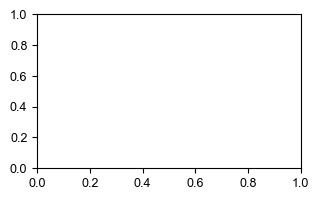

In [ ]:
RUN_LABEL = f"rabi_{min(RABI_MAX_RANGE)*1e-6:.02f}_to_{max(RABI_MAX_RANGE)*1e-6:.02f}_mhz"
errors_freq_nT = list(np.loadtxt(f"errors_nt_freq_{RUN_LABEL}.txt"))
errors_time_nT = list(np.loadtxt(f"errors_nt_time_{RUN_LABEL}.txt", ))
rabi_maxes = list(np.loadtxt(f"rabi_values_{RUN_LABEL}.txt"))

plt.figure(0, figsize=(3.4, 2))
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'arial'

labels = [r"$\langle111\rangle$", r"$\langle1\bar{1}1\rangle$", r"$\langle11\bar{1}\rangle$", r"$\langle\bar{1}11\rangle$"]
plt.plot(1e-6*np.array(rabi_maxes), errors_time_nT, label = labels)
plt.plot(1e-6*np.array(rabi_maxes), 1/(1e-6*np.array(rabi_maxes)))
plt.legend(loc="lower right", ncol=2)
plt.xlabel(r"$\Omega_\text{max}/2\pi$ (MHz)")
plt.ylabel("Inversion error (nT)")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both", width=1.5)
plt.gca().tick_params(direction="in", which = "minor", length=2.5)
plt.gca().tick_params(direction="in", which = "major", length=5)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.25)
plt.ylim((-2, 2))

In [132]:
RUN_LABEL = f"rabi_50.00_to_150.00_mhz"
base_path = "/Users/lilianchildress/Documents/GitHub/sbq-dq-simulator/"
errors_vs_b_freq_domain_nT = list(np.loadtxt(base_path + f"errors_nt_freq_{RUN_LABEL}.txt"))
errors_vs_b_time_domain_nT = list(np.loadtxt(base_path + f"errors_nt_time_{RUN_LABEL}.txt", ))
rabi_maxes = list(np.loadtxt(base_path+ f"rabi_values_{RUN_LABEL}.txt"))

np.array(errors_vs_b_freq_domain_nT).shape

(79, 4)

What's going on at 147 MHz?

In [ ]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

NOMINAL_RABI_FREQ_BASE_HZ = 100e6
RABI_MAX_RANGE = np.linspace(147e6, 147e6, 1)
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

def ramsey_summed_dtft_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings, ramseyfreqs):
    return np.sum(np.array([double_cosine_inner_product(sq_cancelled_signal, rabi_freq[0], ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs]))

def find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 11), rabifreqs=np.linspace(20e6, 150e6, 201), height_factor = 0.5, prominence_factor = 0.5, ordering=[0,1,3,2]):

    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)

    min_rs = min(ramsey_summed)
    peaks = find_peaks(
        -ramsey_summed,
        height=(-min_rs) * height_factor,
        prominence=(-min_rs) * prominence_factor,
    )
    if len(peaks[0])!= 4:
        plt.plot(rabifreqs, ramsey_summed)
        plt.show()
    while len(peaks[0]) < 4:
        print(f"Did not find all peaks! Found only {len(peaks[0])}")
        height_factor = height_factor*0.75
        prominence_factor = prominence_factor*0.75
        peaks = find_peaks(
            -ramsey_summed,
            height=(-min_rs) * height_factor,
            prominence=(-min_rs) * prominence_factor,
        )

    rabi_frequencies = []
    for rabi_guess in rabifreqs[peaks[0]]:
        peak = minimize(ramsey_summed_dtft_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings, ramseyfreqs), method="Nelder-Mead")
        rabi_frequencies.append(peak.x[0])

    return np.array(rabi_frequencies)[ordering]

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)

#rabi_maxes = []
#errors_freq_nT = []
#errors_time_nT = []

for rabi_max in RABI_MAX_RANGE:

    # Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
    exp_param_factory.set_base_rabi_frequency(rabi_max)
    sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

    larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
    ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
    print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")
    # Run the analysis assuming the nominal Rabi frequency
    exp_param_factory.set_base_rabi_frequency(NOMINAL_RABI_FREQ_BASE_HZ)
    rabi_frequencies=find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings)
    print(f"Extracted Rabi frequencies: {np.array2string(rabi_frequencies*1e-6, precision=2)}")
    try:    
        # frequency domain inversion
        peakfit_results = double_cosine_inner_product_fit_inversion(
            sq_cancelled_signal,
            rabi_frequencies,
            inner_product_settings,
            RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
            T2STAR_S,
            constrain_same_width=True,
            allow_zero_peak=True,
        )
        errors_fd_nT = fit_vs_eigenvalue_error_all_orientations_nT(peakfit_results, larmor_freqs_all_axes_hz)
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz, freq domain errors = {np.array2string(errors_fd_nT[:, PEAK_INDEX], precision=2)} nT") 

        # time domain inversion
        freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
        time_domain_fit_results = time_domain_fit_inversion(
            sq_cancelled_signal, 
            exp_param_factory.get_experiment_parameters(), 
            inner_product_settings, 
            freq_guesses_all_orientations, 
            T2STAR_S,
            fix_phase_to_zero= False,
            constrain_same_decay= True,
            constrain_hyperfine_freqs= True, 
            rabi_frequencies=rabi_frequencies)
        errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
        print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

        #rabi_maxes.append(rabi_max)
        #errors_freq_nT.append(errors_fd_nT[:, PEAK_INDEX])
        #errors_time_nT.append(errors_td_nT[:, PEAK_INDEX])
        
    except ValueError:
        print(f"Rabi_max = {1e-6*rabi_max:.2f} MHz generated ValueError ")

Ideal Rabi frequencies: [ 97.56 116.39 136.35 126.37]
Extracted Rabi frequencies: [ 97.53 116.36 136.34 126.37]
Rabi_max = 147.00 MHz, freq domain errors = [42.98 -8.47 -3.7  12.94] nT
	 	 	 time domain fit errors = [ 0.08   0.017 -0.039  0.022] nT


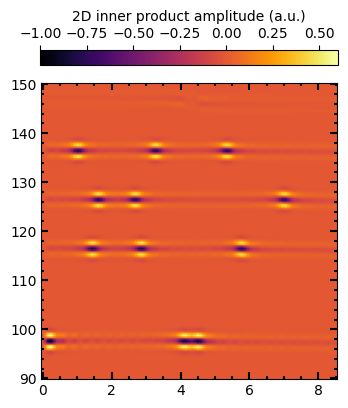

In [97]:
ramseyfreqs = np.linspace(0, 8.5e6, 101)
rabifreqs = np.linspace(90e6, 150e6, 201)
dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
imshow_with_extents_and_crop(HZ_TO_MHZ*ramseyfreqs,HZ_TO_MHZ*rabifreqs, -dtft/min(dtft.flatten()),ymin=90, ymax=150, xmin=0, xmax=8.5)
plt.colorbar(orientation="horizontal",location="top", shrink=0.6, label="2D inner product amplitude (a.u.)")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both", width=1.5)
plt.gca().tick_params(direction="in", which = "minor", length=2.5)
plt.gca().tick_params(direction="in", which = "major", length=5)
plt.show()

### Vs MW angle

In [4]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize

from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6
RAD_TO_DEGREE = 360/(2*np.pi)

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
NOMINAL_MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
NOMINAL_MW_THETA = 0.23957582149174544
NOMINAL_MW_PHI = 0.5244528089360776
MW_THETA_EXCURSION = 10/RAD_TO_DEGREE
MW_PHI_EXCURSION = 10/RAD_TO_DEGREE

MW_THETA_RANGE = np.linspace(NOMINAL_MW_THETA - MW_THETA_EXCURSION/2, NOMINAL_MW_THETA + MW_THETA_EXCURSION/2, 25)
MW_PHI_RANGE = np.linspace(NOMINAL_MW_PHI - MW_PHI_EXCURSION/2, NOMINAL_MW_PHI + MW_PHI_EXCURSION/2, 25)

E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

def ramsey_summed_dtft_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings, ramseyfreqs):
    return np.sum(np.array([double_cosine_inner_product(sq_cancelled_signal, rabi_freq[0], ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs]))

def find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 11), rabifreqs=np.linspace(50e6, 100e6, 101), height_factor = 0.5, prominence_factor = 0.5, ordering=[0,1,3,2]):

    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)

    min_rs = min(ramsey_summed)
    peaks = find_peaks(
        -ramsey_summed,
        height=(-min_rs) * height_factor,
        prominence=(-min_rs) * prominence_factor,
    )
    if len(peaks[0])!= 4:
        plt.plot(rabifreqs, ramsey_summed)
        plt.show()
    while len(peaks[0]) < 4:
        print(f"Did not find all peaks! Found only {len(peaks[0])}")
        height_factor = height_factor*0.75
        prominence_factor = prominence_factor*0.75
        peaks = find_peaks(
            -ramsey_summed,
            height=(-min_rs) * height_factor,
            prominence=(-min_rs) * prominence_factor,
        )

    rabi_frequencies = []
    for rabi_guess in rabifreqs[peaks[0]]:
        peak = minimize(ramsey_summed_dtft_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings, ramseyfreqs), method="Nelder-Mead")
        rabi_frequencies.append(peak.x[0])

    return np.array(rabi_frequencies)[ordering]

def angles_already_evaluated(test_theta, test_phi, theta_values, phi_values):
    theta_indices = np.where(np.isclose(theta_values, test_theta))
    phi_indices = np.where(np.isclose(phi_values, test_phi))
    return len(np.intersect1d(theta_indices, phi_indices)) > 0

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)

mw_theta_values = []
mw_phi_values = []
errors_freq_nT = []
errors_time_nT = []

for theta in MW_THETA_RANGE:
    for phi in MW_PHI_RANGE:
        if not angles_already_evaluated(theta, phi, mw_theta_values, mw_phi_values):
            mw_direction = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
            # Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
            exp_param_factory.set_mw_direction(mw_direction)
            sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

            larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
            ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
            print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")
            # Run the analysis with extracted Rabi frequencies from the data
            rabi_frequencies=find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings)
            print(f"Extracted Rabi frequencies: {np.array2string(rabi_frequencies*1e-6, precision=2)}")
            try:    
                # frequency domain inversion
                peakfit_results = double_cosine_inner_product_fit_inversion(
                    sq_cancelled_signal,
                    rabi_frequencies,
                    inner_product_settings,
                    RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
                    T2STAR_S,
                    constrain_same_width=True,
                    allow_zero_peak=True,
                )
                errors_fd_nT = fit_vs_eigenvalue_error_all_orientations_nT(peakfit_results, larmor_freqs_all_axes_hz)
                print(f"theta = {theta:.2f}, phi = {phi:.2f}, freq domain errors = {np.array2string(errors_fd_nT[:, PEAK_INDEX], precision=2)} nT") 

                # time domain inversion
                freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
                time_domain_fit_results = time_domain_fit_inversion(
                    sq_cancelled_signal, 
                    exp_param_factory.get_experiment_parameters(), 
                    inner_product_settings, 
                    freq_guesses_all_orientations, 
                    T2STAR_S,
                    fix_phase_to_zero= False,
                    constrain_same_decay= True,
                    constrain_hyperfine_freqs= True, 
                    rabi_frequencies=rabi_frequencies)
                errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
                print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

                mw_theta_values.append(theta)
                mw_phi_values.append(phi)
                errors_freq_nT.append(errors_fd_nT[:, PEAK_INDEX])
                errors_time_nT.append(errors_td_nT[:, PEAK_INDEX])
            
            except ValueError:
                print(f"theta = {theta:.2f}, phi = {phi:.2f} MHz generated ValueError ")

Ideal Rabi frequencies: [72.66 79.01 89.09 84.9 ]
Extracted Rabi frequencies: [72.62 78.98 89.08 84.91]
theta = 0.15, phi = 0.44, freq domain errors = [43.29 -4.29 -3.65  8.86] nT
	 	 	 time domain fit errors = [1.246 0.123 0.019 0.259] nT
Ideal Rabi frequencies: [72.63 79.08 89.1  84.85]
Extracted Rabi frequencies: [72.59 79.04 89.09 84.86]


KeyboardInterrupt: 

In [80]:
def get_rms_error_within_range( theta_range,phi_range, phi_values_total, theta_values_total, errors_vs_b_nT_total, orientation):
    masks = np.array([theta_values_total*360/(2*np.pi) < theta_range[1], theta_values_total*360/(2*np.pi) > theta_range[0], phi_values_total*360/(2*np.pi) < phi_range[1],phi_values_total*360/(2*np.pi) > phi_range[0]])
    mask = np.all(masks, axis=0)
    errors_vs_b_nT_masked = errors_vs_b_nT_total[mask]
    return np.sqrt(np.mean(errors_vs_b_nT_masked[:,orientation]**2))

def plot_errors_all_orientations(theta_values_total, phi_values_total, errors_vs_b_nT_total, plot_half_hyperfine=False, log_plot=True, vmin= 0.01, vmax=300):
    plotstyle = "log" if log_plot else "linear"
    
    theta_ranges = [[90,180],[90,180],[0,90],[0,90]]
    phi_ranges = [[155, 295], [155-90, 295-90],[155, 295], [155-90, 295-90]]
    labels = [r"$\langle111\rangle$", r"$\langle1\bar{1}1\rangle$", r"$\langle11\bar{1}\rangle$", r"$\langle\bar{1}11\rangle$"]
    positions = [[2,4],[2,4],[2,155], [2, 155]]
    errors = [get_rms_error_within_range(theta_ranges[i], phi_ranges[i], np.array(phi_values_total), np.array(theta_values_total), np.array(errors_vs_b_nT_total), i) for i in range(4)]
    error_labels = [f"{errors[i]:.2f}\nnT-rms" for i in range(4)]
    error_positions=[[185, 120], [85, 120], [185, 15], [85, 15]]

    plt.rcParams['font.size'] = 9
    plt.rcParams['font.family'] = 'arial'
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    fig.set_figheight(3)
    fig.set_figwidth(3.4)
    for i, ax in enumerate(axes.flat):
        im=ax.tripcolor(np.array(phi_values_total)*RAD_TO_DEGREE, np.array(theta_values_total)*RAD_TO_DEGREE, np.abs(np.array(errors_vs_b_nT_total)[:,i]),cmap="inferno", norm=plotstyle, vmin=vmin, vmax=vmax)
        if i == 2 or i == 3:
            ax.set_xlabel("Azimuthal angle (deg.)", fontsize=9)
        if i==0 or i ==2:
            ax.set_ylabel("Polar angle (deg.)", fontsize=9)
        if i == 2:
            ax.scatter(NOMINAL_MW_PHI*RAD_TO_DEGREE, NOMINAL_MW_THETA*RAD_TO_DEGREE, marker="x", color = "cyan")
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")
        ax.minorticks_on()
        ax.tick_params(direction="in", which = "both", width=1.25)
        ax.tick_params(direction="in", which = "minor", length=2)
        ax.tick_params(direction="in", which = "major", length=3.5)
        for spine in ax.spines.values():
            spine.set_linewidth(1.25)
        #ax.text(positions[i][0], positions[i][1], labels[i], color="white", fontsize=8)
        #ax.text(error_positions[i][0], error_positions[i][1], error_labels[i], color="white", fontsize=8)
        #rms_error = get_rms_error_within_range(theta_ranges[i], phi_ranges[i], np.array(phi_values_total), np.array(theta_values_total), np.array(errors_vs_b_nT_total), i)
        #ax.set_title(
        #    f"Axis: {np.array2string(np.sqrt(3) * NVaxes_100[i], precision=0)}, Rabi: {RABI_FREQUENCIES[i] * 1e-6:.1f} MHz\nrms error ={rms_error:.3f} nT", fontsize=10
        #)
        #ax.vlines(phi_ranges[i], [theta_ranges[i][0]],[theta_ranges[i][1]], linestyle="dotted", color="white")
        #ax.hlines(theta_ranges[i], [phi_ranges[i][0]], [phi_ranges[i][1]], linestyle="dotted", color="white")

        #if i==1:
            #phi_range_full = np.linspace(0, 2*np.pi, 101)
            #theta_no_projection = np.atan2(1, np.sin(phi_range_full) - np.cos(phi_range_full))
            #ax.plot(phi_range_full*RAD_TO_DEGREE, theta_no_projection * RAD_TO_DEGREE, color="white", linestyle="dashdot")

    #cax,kw = colorbar.make_axes(axes, orientation="horizontal")
    #fig.colorbar(im, cax=cax, **kw)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(top=0.8, right=.99, left=0.14, bottom=0.12)
    #cbar_ax = fig.add_axes([.87, 0.15, 0.03, 0.7])
    cbar_ax = fig.add_axes([.25, 0.82, 0.65, 0.03])
    cbar =fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Inversion error (nT)", fontsize=9)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.xaxis.set_ticks_position('top')
    #plt.tight_layout()

In [173]:
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
print(len(NVOrientation))

4


In [87]:
NVaxes_100

[array([0.57735027, 0.57735027, 0.57735027]),
 array([-0.57735027,  0.57735027, -0.57735027]),
 array([-0.57735027, -0.57735027,  0.57735027]),
 array([ 0.57735027, -0.57735027, -0.57735027])]

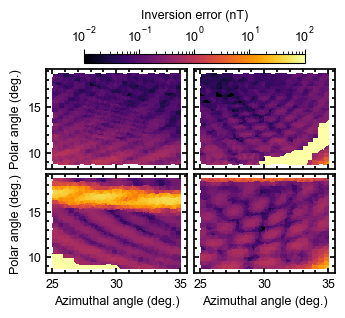

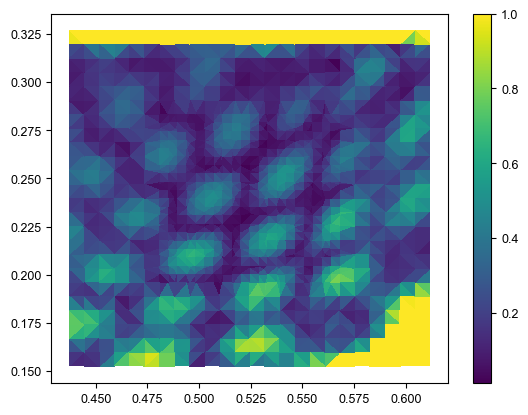

In [57]:
plot_errors_all_orientations(mw_theta_values, mw_phi_values, np.abs(np.array(errors_time_nT)), log_plot=True, vmin=0.01, vmax=100)
plt.show()
plt.tripcolor( mw_phi_values,mw_theta_values,np.abs(np.array(errors_time_nT)[:,3]), vmax=1)
plt.colorbar()

In [54]:
mw_phi_values = list(np.loadtxt("mw_phi_values"))
mw_theta_values = list(np.loadtxt("mw_theta_values"))
errors_time_nT = list(np.loadtxt("mw_angle_error_time_nT"))

In [163]:
np.savetxt("mw_phi_values", mw_phi_values)
np.savetxt("mw_theta_values", mw_theta_values)
np.savetxt("mw_angle_error_time_nT", errors_time_nT)


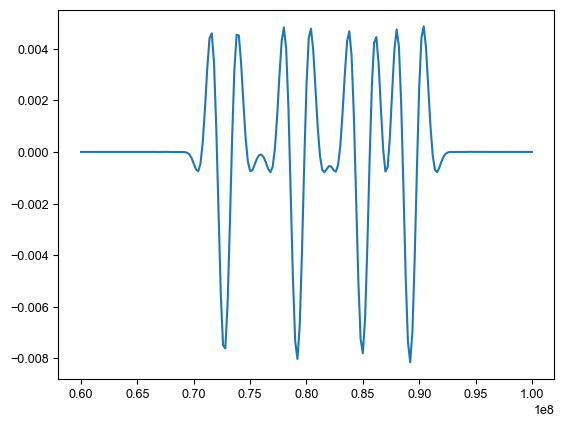

In [8]:
import numpy as np
from scipy.signal import windows
from bff_paper_figures.inner_product_functions import inner_product_sinusoid

ramseyfreqs = np.linspace(0, 8.5e6, 11)
rabifreqs = np.linspace(60e6, 100e6, 201)
#dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
#ramsey_summed = np.sum(dtft, axis=1)
window = windows.get_window("blackman", len(inner_product_settings.mw_pulse_durations_s))
ramsey_summed2 = -np.array([np.sum(inner_product_sinusoid(np.cos, rabi_freq, inner_product_settings.mw_pulse_durations_s, window*np.transpose(sq_cancelled_signal), axis=1)) for rabi_freq in rabifreqs])/len(inner_product_settings.free_evolution_times_s)/4
#plt.plot(rabifreqs, ramsey_summed)
plt.plot(rabifreqs, ramsey_summed2)

In [29]:
SLIGHT_DECREASE_FACTOR = 0.8

def ramsey_summed_dtft_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings, ramseyfreqs):
    return np.sum(np.array([double_cosine_inner_product(sq_cancelled_signal, rabi_freq[0], ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs]))

def find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 11), rabifreqs=np.linspace(50e6, 100e6, 101), height_factor = 0.5, prominence_factor = 0.5, ordering=[0,1,3,2]):

    # Calculate the inner product summed over Ramsey frequencies
    dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
    ramsey_summed = np.sum(dtft, axis=1)

    min_rs = min(ramsey_summed)
    peaks = find_peaks(
        -ramsey_summed,
        height=(-min_rs) * height_factor,
        prominence=(-min_rs) * prominence_factor,
    )

    while len(peaks[0]) < 4:
        print(f"Did not find all peaks! Found only {len(peaks[0])}. Trying again...")
        height_factor = height_factor*SLIGHT_DECREASE_FACTOR
        prominence_factor = prominence_factor*SLIGHT_DECREASE_FACTOR
        peaks = find_peaks(
            -ramsey_summed,
            height=(-min_rs) * height_factor,
            prominence=(-min_rs) * prominence_factor,
        )

    if len(peaks[0]) != len(NVOrientation):
        raise ValueError("Could not find 4 rabi frequencies")
    
    rabi_frequencies = []
    for rabi_guess in rabifreqs[peaks[0]]:
        peak = minimize(ramsey_summed_dtft_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings, ramseyfreqs), method="Nelder-Mead")
        rabi_frequencies.append(peak.x[0])

    return np.array(rabi_frequencies)[ordering]

In [30]:
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")
# Run the analysis with extracted Rabi frequencies from the data
rabi_frequencies=find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings)
print(f"Extracted Rabi frequencies: {np.array2string(rabi_frequencies*1e-6, precision=2)}")

Ideal Rabi frequencies: [72.63 79.08 89.1  84.85]
Extracted Rabi frequencies: [72.59 79.04 89.09 84.86]


In [ ]:
SLIGHT_DECREASE_FACTOR = 0.8

def ramsey_summed_rabi_inner_product_to_minimize(rabi_freq, sq_cancelled_signal, inner_product_settings):
    window = windows.get_window(inner_product_settings.rabi_window, len(inner_product_settings.mw_pulse_durations_s))
    return -np.sum(inner_product_sinusoid(np.cos, rabi_freq[0], inner_product_settings.mw_pulse_durations_s, window*np.transpose(sq_cancelled_signal), axis=1))

def find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings, ramseyfreqs= np.linspace(0, 8.5e6, 11), rabifreqs=np.linspace(50e6, 100e6, 101), height_factor = 0.75, prominence_factor = 0.75, ordering=[0,1,3,2]):

    # Calculate the inner product summed over Ramsey durations
    window = windows.get_window("blackman", len(inner_product_settings.mw_pulse_durations_s))
    ramsey_summed = np.array([np.sum(inner_product_sinusoid(np.cos, rabi_freq, inner_product_settings.mw_pulse_durations_s, window*np.transpose(sq_cancelled_signal), axis=1)) for rabi_freq in rabifreqs])

    max_rs = max(ramsey_summed)
    peaks = find_peaks(
        ramsey_summed,
        height=(max_rs) * height_factor,
        prominence=(-max_rs) * prominence_factor,
    )

    while len(peaks[0]) < 4:
        print(f"Did not find all peaks! Found only {len(peaks[0])}. Trying again...")
        height_factor = height_factor*SLIGHT_DECREASE_FACTOR
        prominence_factor = prominence_factor*SLIGHT_DECREASE_FACTOR
        peaks = find_peaks(
            ramsey_summed,
            height=(max_rs) * height_factor,
            prominence=(-max_rs) * prominence_factor,
        )

    if len(peaks[0]) != len(NVOrientation):
        plt.plot(rabifreqs, ramsey_summed)
        raise ValueError("Could not find 4 rabi frequencies")
    
    rabi_frequencies = []
    for rabi_guess in rabifreqs[peaks[0]]:
        peak = minimize(ramsey_summed_rabi_inner_product_to_minimize, [rabi_guess], (sq_cancelled_signal, inner_product_settings), method="Powell")
        rabi_frequencies.append(peak.x[0])

    return np.array(rabi_frequencies)[ordering]

Ideal Rabi frequencies: [72.63 79.08 89.1  84.85]
Extracted Rabi frequencies: [72.71 79.17 89.18 84.96]


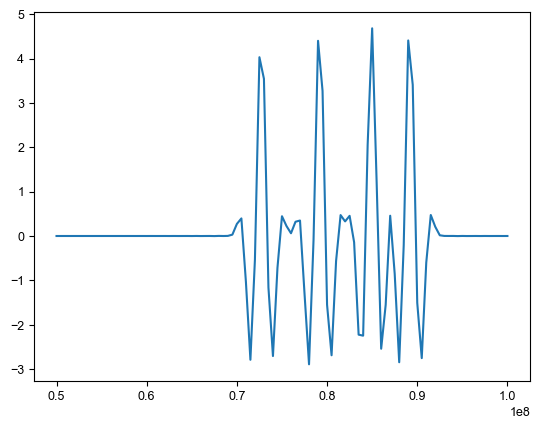

In [49]:
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")
# Run the analysis with extracted Rabi frequencies from the data
rabi_frequencies=find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings)
print(f"Extracted Rabi frequencies: {np.array2string(rabi_frequencies*1e-6, precision=2)}")

In [ ]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize

from bff_simulator.constants import exy, NVaxes_100, gammab, f_h
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations, N_HYPERFINE

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6
RAD_TO_DEGREE = 360/(2*np.pi)

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
NOMINAL_MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
NOMINAL_MW_THETA = 0.23957582149174544
NOMINAL_MW_PHI = 0.5244528089360776
MW_THETA_EXCURSION = 10/RAD_TO_DEGREE
MW_PHI_EXCURSION = 10/RAD_TO_DEGREE

MW_THETA_RANGE = np.linspace(NOMINAL_MW_THETA - MW_THETA_EXCURSION, NOMINAL_MW_THETA + MW_THETA_EXCURSION/2, 25)
MW_PHI_RANGE = np.linspace(NOMINAL_MW_PHI - MW_PHI_EXCURSION, NOMINAL_MW_PHI - MW_PHI_EXCURSION/2, 13)

E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

def angles_already_evaluated(test_theta, test_phi, theta_values, phi_values):
    theta_indices = np.where(np.isclose(theta_values, test_theta))
    phi_indices = np.where(np.isclose(phi_values, test_phi))
    return len(np.intersect1d(theta_indices, phi_indices)) > 0

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)

#mw_theta_values = []
#mw_phi_values = []
#errors_freq_nT = []
#errors_time_nT = []

for theta in MW_THETA_RANGE:
    for phi in MW_PHI_RANGE:
        if not angles_already_evaluated(theta, phi, mw_theta_values, mw_phi_values):
            mw_direction = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
            # Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
            exp_param_factory.set_mw_direction(mw_direction)
            sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

            larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
            ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
            print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")
            # Run the analysis with extracted Rabi frequencies from the data
            try:    
                rabi_frequencies=find_rabi_frequencies_from_signal(sq_cancelled_signal, inner_product_settings)
                print(f"Extracted Rabi frequencies: {np.array2string(rabi_frequencies*1e-6, precision=2)}")
                freq_guesses_all_orientations = []
                for orientation in NVOrientation:
                    cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
                        sq_cancelled_signal, rabi_frequencies[orientation], RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
                    )
                    min_inner_product = min(cos_cos_inner_prod)
                    peaks = find_peaks(
                        -cos_cos_inner_prod,
                        height=(-min_inner_product) * height_factor,
                        prominence=(-min_inner_product) * prominence_factor,
                    )
                    rightmost_peak_location = RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ[peaks[0][-1]]
                    freq_guesses_all_orientations.append([rightmost_peak_location - 2*f_h*i for i in range(N_HYPERFINE)])


                time_domain_fit_results = time_domain_fit_inversion(
                    sq_cancelled_signal, 
                    exp_param_factory.get_experiment_parameters(), 
                    inner_product_settings, 
                    np.array(freq_guesses_all_orientations), 
                    T2STAR_S,
                    fix_phase_to_zero= False,
                    constrain_same_decay= True,
                    constrain_hyperfine_freqs= True, 
                    rabi_frequencies=rabi_frequencies)
                errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
                print(f"theta = {theta:.2f}, phi = {phi:.2f}, time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

                mw_theta_values.append(theta)
                mw_phi_values.append(phi)
                errors_freq_nT.append(errors_fd_nT[:, PEAK_INDEX])
                errors_time_nT.append(errors_td_nT[:, PEAK_INDEX])
            
            except ValueError:
                print(f"theta = {theta:.2f}, phi = {phi:.2f} MHz generated ValueError ")

Ideal Rabi frequencies: [78.12 80.11 84.92 83.27]
Did not find all peaks! Found only 3. Trying again...
Extracted Rabi frequencies: [78.13 80.28 85.14 83.21]
theta = 0.07, phi = 0.35, time domain fit errors = [-239.46    95.155  300.778  347.986] nT
Ideal Rabi frequencies: [78.11 80.14 84.93 83.25]
Did not find all peaks! Found only 3. Trying again...
Extracted Rabi frequencies: [78.13 80.3  85.15 83.19]
theta = 0.07, phi = 0.36, time domain fit errors = [309.597 127.682 248.661 300.692] nT
Ideal Rabi frequencies: [78.1  80.16 84.94 83.22]
Extracted Rabi frequencies: [78.12 80.32 85.15 83.17]
theta = 0.07, phi = 0.36, time domain fit errors = [371.469 156.521 201.317 259.616] nT
Ideal Rabi frequencies: [78.08 80.19 84.95 83.2 ]
Extracted Rabi frequencies: [78.12 80.34 85.16 83.15]
theta = 0.07, phi = 0.37, time domain fit errors = [425.07  181.81  158.282 224.225] nT
Ideal Rabi frequencies: [78.07 80.22 84.96 83.17]
Extracted Rabi frequencies: [78.12 80.36 85.16 83.14]
theta = 0.07, ph

In [72]:
np.savetxt("mw_phi_values2", mw_phi_values)
np.savetxt("mw_theta_values2", mw_theta_values)
np.savetxt("mw_angle_error_time_nT2", errors_time_nT)

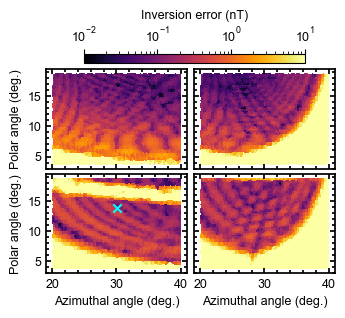

In [84]:
plot_errors_all_orientations(mw_theta_values, mw_phi_values, np.abs(np.array(errors_time_nT)), log_plot=True, vmin=0.01, vmax=10)
plt.show()


You were going to try to speed up the time domain inversion by not doing a full frequency domain inversion to get the initial guesses. Is just the peak-finding good enough?

In [86]:
from bff_paper_figures.inner_product_functions import double_cosine_inner_product, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import fit_three_cos_model, N_HYPERFINE
from bff_simulator.constants import f_h

ramsey_freqs_range_hz = RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ
height_factor = 0.5
prominence_factor = 0.5

larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())

peakfit_results = double_cosine_inner_product_fit_inversion(
    sq_cancelled_signal,
    rabi_frequencies,
    inner_product_settings,
    RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
    T2STAR_S,
    constrain_same_width=True,
    allow_zero_peak=True,
)
freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
time_domain_fit_results = time_domain_fit_inversion(
    sq_cancelled_signal, 
    exp_param_factory.get_experiment_parameters(), 
    inner_product_settings, 
    freq_guesses_all_orientations, 
    T2STAR_S,
    fix_phase_to_zero= False,
    constrain_same_decay= True,
    constrain_hyperfine_freqs= True, 
    rabi_frequencies=rabi_frequencies)
errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

new_fit_results = []
for orientation in NVOrientation:
    cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
        sq_cancelled_signal, rabi_frequencies[orientation], ramsey_freqs_range_hz, inner_product_settings
    )
    min_inner_product = min(cos_cos_inner_prod)
    peaks = find_peaks(
        -cos_cos_inner_prod,
        height=(-min_inner_product) * height_factor,
        prominence=(-min_inner_product) * prominence_factor,
    )
    rightmost_peak_location = ramsey_freqs_range_hz[peaks[0][-1]]
    freq_guesses = ([rightmost_peak_location - 2*f_h*i for i in range(N_HYPERFINE)])

    rabi_window = windows.get_window(inner_product_settings.rabi_window, len(inner_product_settings.mw_pulse_durations_s))
    time_domain_ramsey_signal = inner_product_sinusoid(np.cos, rabi_frequencies[orientation], inner_product_settings.mw_pulse_durations_s, rabi_window*np.transpose(sq_cancelled_signal),axis=1)
    time_domain_result = fit_three_cos_model(inner_product_settings.free_evolution_times_s, time_domain_ramsey_signal, freq_guesses, T2STAR_S, False, True, True)
    new_fit_results.append(time_domain_result)
errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(new_fit_results, larmor_freqs_all_axes_hz)
print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")



	 	 	 time domain fit errors = [-0.101  0.081  0.142 -0.436] nT
	 	 	 time domain fit errors = [-0.101  0.081  0.142 -0.436] nT


Looks like we don't need to do all the work of fitting in frequency space first!

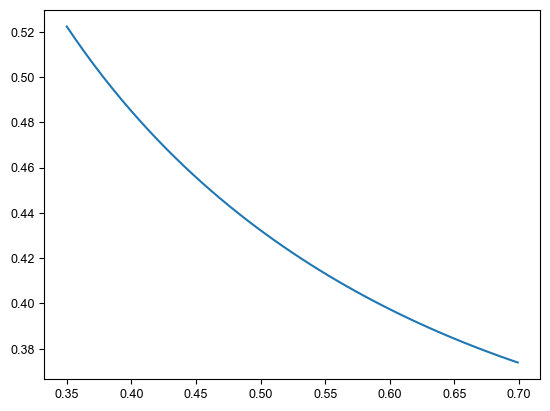

In [103]:
from scipy.optimize import fsolve
from bff_simulator.constants import NVaxes_100
from bff_simulator.vector_manipulation import perpendicular_projection

def rabi_difference_to_crosstalk_harmonic(theta:float, phi:float, crosstalk_orientation: int, harmonic: float, target_orientation: int):
    mw_direction = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
    return harmonic*perpendicular_projection(NVaxes_100[crosstalk_orientation], mw_direction) - perpendicular_projection(NVaxes_100[target_orientation], mw_direction)
phi_crosstalk_rad = np.linspace(min(mw_phi_values), max(mw_phi_values), 51)
theta_crosstalk_rad = [fsolve(rabi_difference_to_crosstalk_harmonic, [.5], (phi, 0, 1.5, 1)) for phi in phi_crosstalk_rad]
plt.plot(phi_crosstalk_rad, theta_crosstalk_rad)


In [115]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize

from bff_simulator.constants import exy, NVaxes_100, gammab, f_h
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.extract_experiment_values import get_ideal_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations, N_HYPERFINE

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6
RAD_TO_DEGREE = 360/(2*np.pi)

MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"

E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak

RABI_FREQUENCY_ERRORS = np.linspace(-.01, .01, 101)

def angles_already_evaluated(test_theta, test_phi, theta_values, phi_values):
    theta_indices = np.where(np.isclose(theta_values, test_theta))
    phi_indices = np.where(np.isclose(phi_values, test_phi))
    return len(np.intersect1d(theta_indices, phi_indices)) > 0

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

theta = B_THETA
phi = B_PHI
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)


# Run the experiment at a slightly different Rabi frequency (corresponding to amplifier drift) and calculate the 
exp_param_factory.set_mw_direction(MW_DIRECTION)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
ideal_rabi_frequencies = get_ideal_rabi_frequencies(exp_param_factory.get_experiment_parameters())
print(f"Ideal Rabi frequencies: {np.array2string(ideal_rabi_frequencies*1e-6, precision=2)}")

errors_vs_rabierror_time_nT = []
rabi_error_values = []
for rabi_error in RABI_FREQUENCY_ERRORS:
    try:    
        # Analyze the data with an error in the Rabi frequency
        rabi_frequencies=(1+rabi_error)*ideal_rabi_frequencies

        # Find initial guesses for Ramsey frequencies
        freq_guesses_all_orientations = []
        for orientation in NVOrientation:
            cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
                sq_cancelled_signal, rabi_frequencies[orientation], RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
            )

            min_inner_product = min(cos_cos_inner_prod)
            peaks = find_peaks(
                -cos_cos_inner_prod,
                height=(-min_inner_product) * height_factor,
                prominence=(-min_inner_product) * prominence_factor,
            )
            rightmost_peak_location = RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ[peaks[0][-1]]
            freq_guesses_all_orientations.append([rightmost_peak_location - 2*f_h*i for i in range(N_HYPERFINE)])

        # Do the time domain inversion
        time_domain_fit_results = time_domain_fit_inversion(
            sq_cancelled_signal, 
            exp_param_factory.get_experiment_parameters(), 
            inner_product_settings, 
            np.array(freq_guesses_all_orientations), 
            T2STAR_S,
            fix_phase_to_zero= False,
            constrain_same_decay= True,
            constrain_hyperfine_freqs= True, 
            rabi_frequencies=rabi_frequencies)
        errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
        print(f"Rabi error = {rabi_error*100:.1f}%, time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")
        errors_vs_rabierror_time_nT.append(errors_td_nT)
        rabi_error_values.append(rabi_error)

    except (ValueError, IndexError):
        print(f"Rabi error = {rabi_error*100:.1f}% generated ValueError ")


Ideal Rabi frequencies: [66.36 79.17 92.76 85.97]
Rabi error = -1.0% generated ValueError 
Rabi error = -1.0% generated ValueError 
Rabi error = -1.0% generated ValueError 
Rabi error = -0.9% generated ValueError 
Rabi error = -0.9% generated ValueError 
Rabi error = -0.9% generated ValueError 
Rabi error = -0.9% generated ValueError 
Rabi error = -0.9% generated ValueError 
Rabi error = -0.8% generated ValueError 
Rabi error = -0.8% generated ValueError 
Rabi error = -0.8% generated ValueError 
Rabi error = -0.8% generated ValueError 
Rabi error = -0.8% generated ValueError 
Rabi error = -0.7% generated ValueError 
Rabi error = -0.7% generated ValueError 
Rabi error = -0.7%, time domain fit errors = [-0.513 -0.355  0.278 -0.336] nT
Rabi error = -0.7%, time domain fit errors = [-0.468 -0.15   0.078 -0.379] nT
Rabi error = -0.7%, time domain fit errors = [-0.422  0.041 -0.134 -0.445] nT
Rabi error = -0.6%, time domain fit errors = [-0.379  0.192 -0.274 -0.535] nT
Rabi error = -0.6%, tim

(-2.0, 2.0)

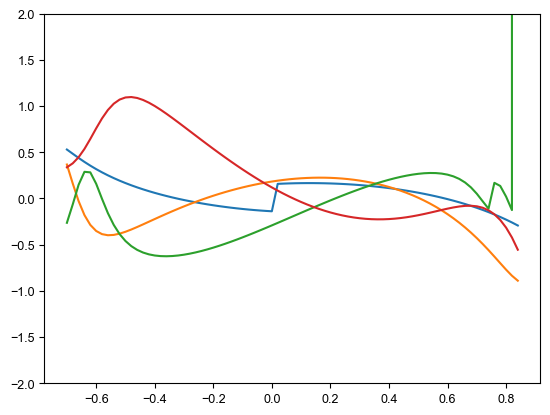

In [119]:
plt.plot(np.array(rabi_error_values)*100, np.array(errors_vs_rabierror_time_nT)[:,:,2])
plt.ylim([-2,2])